<a href="https://colab.research.google.com/github/reejungkim/Pipeline/blob/main/prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import libraries

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Load up packages
import os
import pandas as pd
import numpy as np
import sklearn

#visualization lisb
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_palette('Set2')

#split data set
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score

#feature selection
from sklearn import feature_selection

#preprocessing libs
#scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
#pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin
#label encoders
from sklearn.preprocessing import LabelEncoder,  OrdinalEncoder, OneHotEncoder

#Models
#classifiers
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
#regressors
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor


#model evaluation libs
#classifier evaluation
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#regressor evaluation
from sklearn.metrics import r2_score, mean_squared_error

#number of features optimization
from sklearn.model_selection import StratifiedKFold

#Hyper-parameter optimization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


# Load data set

In [61]:
# Load data
#df = pd.read_csv('bankruptcy_Train.csv')

#df = sns.load_dataset('diamonds')
#df.head()


# Seaborn 데이터셋 목록
sns.get_dataset_names()

df = sns.load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [62]:
features = df.loc[:, df.columns!='survived']
output = df.loc[:, df.columns=='survived']

# Split data set

In [63]:
X_train, X_test, y_train, y_test = train_test_split(features, output, 
                                                    test_size=0.2,
                                                    random_state=52)

# Exploratory Data Analysis

In [7]:
pd.concat( [ df.dtypes.rename('dtype') , df.iloc[0].rename('example') ], axis=1 ) 

,dtype,example
survived,int64,0
pclass,int64,3
sex,object,male
age,float64,22.0
sibsp,int64,1
parch,int64,0
fare,float64,7.25
embarked,object,S
class,category,Third
who,object,man


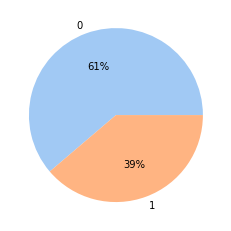

In [64]:
labels = [0,1]
sizes = [y_train['survived'].value_counts()[0],
         y_train['survived'].value_counts()[1]]

colors = sns.color_palette('pastel')
plt.pie(sizes, labels=labels,  autopct='%.0f%%', colors=colors)
plt.show()

In [65]:
# checking for sparse columns 
#(df.isnull().sum()/ len(df).sort_values(ascending=False)[:30]
df_null = pd.DataFrame((X_train.isnull().sum()/ len(X_train)), columns={"%missing"}).sort_values(by="%missing", ascending=False)
df_null.loc[df_null['%missing']>=.5]

,%missing
deck,0.759831


should check if the sparse columns refers to zero or n/a before dropping the columns
 

In [82]:
X_train.drop(['deck'], axis=1, inplace=True)

Drop columns logically shouldn't be used

In [81]:
X_train.drop(['alive'], axis=1, inplace=True )

In [68]:
df_no_var = features.std().sort_values(ascending=True)
df_no_var#.loc[df_no_var<=0.2]

adult_male     0.489615
alone          0.489615
parch          0.806057
pclass         0.836071
sibsp          1.102743
age           14.526497
fare          49.693429
dtype: float64

In [69]:
#df.drop(['Attr1', 'Attr2'], axis=1)

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [87]:
cols_obj = X_train.select_dtypes(include=['object','category', 'boolean']).columns

In [88]:
for col in cols_obj:
    print('{}: {}'.format(col, df[col].unique()  ))

sex: ['male' 'female']
embarked: ['S' 'C' 'Q' nan]
class: ['Third', 'First', 'Second']
Categories (3, object): ['First', 'Second', 'Third']
who: ['man' 'woman' 'child']
adult_male: [ True False]
embark_town: ['Southampton' 'Cherbourg' 'Queenstown' nan]
alone: [False  True]


# Pipeline

In [73]:
class AgeCustomImputer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    X['age'] = X.groupby('class')['age'].transform( lambda x: x.fillna(x.median()))
    X['age'] = X['age'].astype('int')
    return X

In [74]:
class NameTransformer(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.name_ls=[]
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    for name_idx in range(len(X['name'])):
      self.name_ls.append(X['name'][name_idx].split(',')[0])
    X['name'] = self.name_ls
    return X

make_column_transformer(
    (StandardScaler(), ['carat', 'depth']),
    (OneHotEncoder(), ['cut']),
    remainder='passthrough'
)

In [89]:
num_pipeline = Pipeline(
    steps = [
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
        ]
)


cat_pipeline = Pipeline(
    steps = [ 
        #('imputer_constant', SimpleImputer(strategy='constant', fill_value='none'),
        ("imputer", SimpleImputer(strategy="most_frequent")),
        #("encoder", OneHotEncoder(handle_unknown="ignore")) 
        ("encoder", OrdinalEncoder()) 
        ]
)


In [90]:
# 수치형 특징의 리스트를 저장한다.
num_x_training = X_train.select_dtypes(include=['number', 'int64', 'float64'] )\
                            .columns \
                            .to_list()
# 범주형 특징의 리스트를 저장한다.
cat_x_training = X_train.select_dtypes(include=['object', 'category', 'boolean'])\
                            .columns \
                            .to_list()

# ColumnTranformer 로 열 변환자 객체 정의
preprocessor = ColumnTransformer([
    ('numeric', num_pipeline, num_x_training),
    ('categorical', cat_pipeline, cat_x_training)  #['sex', 'embarked', 'embark_town']) 
], remainder='drop')

# ColumnTranformer 로 열 변환자 객체 정의
full_pipeline = Pipeline(steps=[
        ("age imputer", AgeCustomImputer()),
        ('preprocessor', preprocessor)
    ]
)

In [91]:
sklearn.set_config(display="diagram")
full_pipeline.fit(X_train)

Pipeline(steps=[('age imputer', AgeCustomImputer()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['pclass', 'age', 'sibsp',
                                                   'parch', 'fare']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['sex', 'embarked', 'class',
                                                   'who', 'adult_male',
                                                   'embark_town',
                                                   'alone'])]))])

sel = feature_selection.VarianceThreshold() #removes all features whose variance doesn’t meet some threshold. By default it removes features with zero variance or features that have the same value for all samples.
train_variance =  sel.fit_transform(preprocessor.transform(X_train))
train_variance

In [92]:
model_candidates = [   
{
    'label':'Random forest classifier',
    'model': RandomForestClassifier(),
},
{
    'label':'GBM classifier',
    'model':GradientBoostingClassifier(),
},
{
    'label': 'XGBoost Classifier',
    'model': XGBClassifier(eval_metric='mlogloss', use_label_encoder=False),#max_depth=10, n_estimators=300, use_label_encoder=False),
#  # 'model': GradientBoostingClassifier(n_estimators=300,max_depth=10)
},
{
    'label':'LightGBM',
    'model': LGBMClassifier()
},
{
    'label':'Logistics',
    'model': LogisticRegression()
}

]

In [93]:
full_pipeline.fit(X_train)

X_train_piped = full_pipeline.transform(X_train)
X_test_piped = full_pipeline.transform(X_test) 

full_pipeline.named_steps

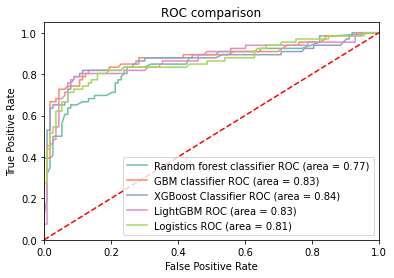

In [94]:
# Below for loop iterates through your models list
for m in model_candidates:
    model = m['model'] # select the model
    model.fit( X_train_piped , y_train) # train the model
    y_pred=model.predict(X_test_piped) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_piped)[:,1])
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score( y_test, model.predict(X_test_piped) )
# Now, plot the computed values
    plt.plot(fpr, tpr, label ='%s ROC (area = %0.2f)' % (m['label'], auc))
    
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC comparison')
plt.legend(loc="lower right")
plt.show()

# Prediction

In [95]:
model = XGBClassifier()
model.fit(X_test_piped, y_test)
y_test_pred = model.predict(X_test_piped)

# Evaluation 

**Regression**
* R-Squared
* RMSE : Root Mean Squared Error [0- infinity]
* MAE : Mean Absolute Error [0- infinity]

**Classification**
* Accuracy
*Precision
*Recall
*Specificity
*F1 Score


* R-squared : how well the predictions approximate the  ground truth [0–100%]
*RMSE and MAE are more interpretable than R-squared and Using the RMSE is more appropriate if the data have a lot of outliers.
*Accuracy : This is a metric that is best used for a balanced data set
*Precision : This metric that’s be used to avoid false positive predict (observation is negative, but is predicted positive)
*Recall / Sensitivity : This metric that’s be used to avoid false negative (Observation is positive, but is predicted negative) and maximize True positive rate.
*Specificity : This metric is used to maximize True negative rate and minimize True positive rate.
*F1 Score : This metric that’s be used to minimize False positive and False negative (일반적으로 크래스 불균형 문제가 있을경우에는 정확도와 정밀도가 높고 재현율이 크게 떨어지는 경향이있음. 따서 정확도, 정밀도, 재현율 가운데 하나의 척도만 사용한다면 모델의 성능을 객관적으로 판단하기 어려움. 그서 정밀도와 재현율의 조화 평균인 F1점수를 사용하는것이 좋다.)




# Evaluatin metrics for regressor models

f1_score(y_test, y_pred, average='micro')

score = mean_absolute_error(y_test, y_pred)
print('MAE:', score)

mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

rmse = np.sqrt(mse)
print('RMSE:', rmse)

# Evaluation metrics for classifier models

In [96]:
pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns = ['predicted Negative', 'Predicted Positive'],
             index = ['Actual Negative', 'Actual Positive'])

,predicted Negative,Predicted Positive
Actual Negative,99,14
Actual Positive,17,49


In [97]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       113
           1       0.78      0.74      0.76        66

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.83       179



In [98]:
X_train.columns

Index(['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class',
       'who', 'adult_male', 'embark_town', 'alone'],
      dtype='object')

In [99]:
pd.DataFrame(X_test_piped)

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.361937,-0.313283,0.427211,0.737515,-0.049758,0.0,2.0,1.0,2.0,0.0,2.0,0.0
1,-0.361937,-0.986496,-0.491745,-0.478019,-0.449965,1.0,2.0,1.0,1.0,1.0,2.0,1.0
2,0.825616,1.631553,-0.491745,-0.478019,-0.506404,1.0,2.0,2.0,1.0,1.0,2.0,1.0
3,0.825616,-0.388085,-0.491745,1.953049,-0.322719,0.0,2.0,2.0,2.0,0.0,2.0,0.0
4,-1.549489,1.481950,0.427211,-0.478019,1.163264,1.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
174,0.825616,1.182745,-0.491745,-0.478019,-0.500247,1.0,2.0,2.0,1.0,1.0,2.0,1.0
175,-0.361937,-0.014078,0.427211,-0.478019,-0.131851,0.0,2.0,1.0,2.0,0.0,2.0,0.0
176,0.825616,-1.884113,-0.491745,1.953049,-0.213432,0.0,2.0,2.0,0.0,0.0,2.0,0.0
177,0.825616,-1.734510,-0.491745,0.737515,-0.409431,1.0,2.0,2.0,0.0,0.0,2.0,0.0


In [100]:
X_train.dtypes

pclass            int64
sex              object
age               int64
sibsp             int64
parch             int64
fare            float64
embarked         object
class          category
who              object
adult_male         bool
embark_town      object
alone              bool
dtype: object

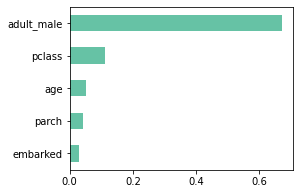

In [101]:
importances = model.feature_importances_
features = X_train.columns

feat_importances = pd.Series(importances, index=features)

feat_importances.nlargest(5).sort_values(ascending=True).plot(kind='barh', figsize=(4, 3))

Text(0.5, 0, 'Permutation Importance')

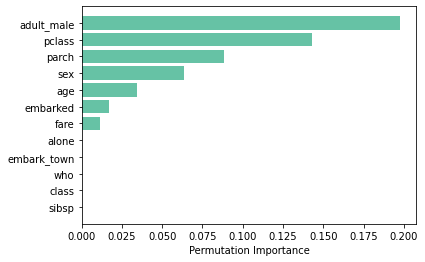

In [102]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test_piped, y_test)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X_train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")